In [1]:
EPOCH = 16

In [2]:
import os
os.environ['KERAS_BACKEND'] = 'torch'
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
from keras.optimizers import Adam
import keras
import numpy as np
import matplotlib.pyplot as plt

from config import config_parser
from mp_util_legacy import preprocess_keypoints_multiple

In [3]:
class KeypointDataGenerator(keras.utils.Sequence):
    def __init__(self, keypoint_path, seq_max_len, batch_size=32, shuffle=False, transform=False):
        self.keypoint_path = keypoint_path
        self.seq_max_len = seq_max_len
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.transform = transform
        
        self.file_list = []
        self.labels = []

        self.all_labels = sorted(os.listdir(keypoint_path))
        for label in self.all_labels:
            for file in os.listdir(os.path.join(keypoint_path, label)):
                self.file_list.append(file)
                self.labels.append(label)
        self.epoch_count = -1
        self.on_epoch_end()

    def reset_epoch(self):
        self.epoch_count = -1
        self.on_epoch_end()

    def on_epoch_end(self):
        self.epoch_count += 1
        np.random.seed(self.epoch_count * 42)
        self.indexes = np.arange(len(self.file_list))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.floor(len(self.file_list) / self.batch_size))
    
    def preprocess_keypoints(self, keypoints):
        angle = np.random.randint(-20, 20)
        tx = np.random.uniform(-0.4, 0.4)
        ty = np.random.uniform(-0.4, 0.4)
        scale = np.random.uniform(0.6, 1.2)
        return preprocess_keypoints_multiple(keypoints, angle=angle, tx=tx, ty=ty, scale=scale)

    def __data_generation(self, indexes):
        sequences = []
        labels = []

        for index in indexes:
            kp_file_name = self.file_list[index]
            label = self.labels[index]
            sequences.append(np.load(os.path.join(self.keypoint_path, label, kp_file_name), mmap_mode="r"))
            labels.append(label)

        for i in range(len(sequences)):
            if self.transform:
                sequences[i] = self.preprocess_keypoints(sequences[i])
            sequences[i] = sequences[i].reshape(self.seq_max_len, -1)

        X = np.array(sequences)
        Y = np.array([self.all_labels.index(label) for label in labels])
        return X, Y
    
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        X, Y = self.__data_generation(indexes)
        return X, Y

In [4]:
training_generator = KeypointDataGenerator(
    "../dataset/minified_3_fixed/split/train", 
    seq_max_len=30, 
    batch_size=32, 
    shuffle=True, 
    transform=True
)
validation_generator = KeypointDataGenerator(
    "../dataset/minified_3_fixed/split/val",
    seq_max_len=30, 
    batch_size=32, 
    shuffle=False, 
    transform=False
)
test_generator = KeypointDataGenerator(
    "../dataset/minified_3_fixed/split/test",
    seq_max_len=30, 
    batch_size=32, 
    shuffle=False, 
    transform=False
)

In [5]:
def train_model(model, learning_rate, epochs):
    training_generator.reset_epoch()
    validation_generator.reset_epoch()
    test_generator.reset_epoch()
    model.summary()
    model.compile(optimizer=Adam(learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(
        training_generator,
        validation_data=validation_generator,
        epochs=epochs,
        verbose=1
    )
    # plot training accuracy and validation accuracy in the same plot
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    # plot training loss and validation loss in the same plot
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # evaluate the model on the test set
    test_loss, test_acc = model.evaluate(test_generator)
    print('Test loss: {}'.format(test_loss))
    print('Test accuracy: {}'.format(test_acc))

    # return training accuracy of last epoch, validation accuracy of last epoch, test accuracy
    return history.history['accuracy'][-1], history.history['val_accuracy'][-1], test_acc

In [6]:
first_batch = training_generator.__getitem__(0)
X_shape = first_batch[0].shape[1:]
Y_shape = len(training_generator.all_labels)
del first_batch
print(X_shape, Y_shape)
results = {}

(30, 468) 9


# Test 1: LSTM vs GRU (Single Layer)

/home/limeboy/CityU_CS/CS4514 Project/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │       305,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 306,825 (1.17 MB)

 Trainable params: 306,825 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

/home/limeboy/CityU_CS/CS4514 Project/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 223ms/step - accuracy: 0.1204 - loss: 2.2475 - val_accuracy: 0.3594 - val_loss: 2.0656
Epoch 2/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - accuracy: 0.4011 - loss: 2.0116 - val_accuracy: 0.4531 - val_loss: 1.9723
Epoch 3/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 369ms/step - accuracy: 0.4204 - loss: 1.8374 - val_accuracy: 0.4219 - val_loss: 1.7455
Epoch 4/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 223ms/step - accuracy: 0.4901 - loss: 1.6389 - val_accuracy: 0.6562 - val_loss: 1.5239
Epoch 5/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/step - accuracy: 0.5781 - loss: 1.4284 - val_accuracy: 0.6094 - val_loss: 1.2906
Epoch 6/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.6334 - loss: 1.2385 - val_accuracy: 0.6875 - val_loss: 1.1355
Epoch 7/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - accuracy: 0.6588 - loss: 1.0404 - val_accuracy: 0.6562 - val_loss: 0.9841
Epoch 8/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 241ms/step - accuracy: 0.6950 - loss: 0.9327 - val_accuracy: 0.

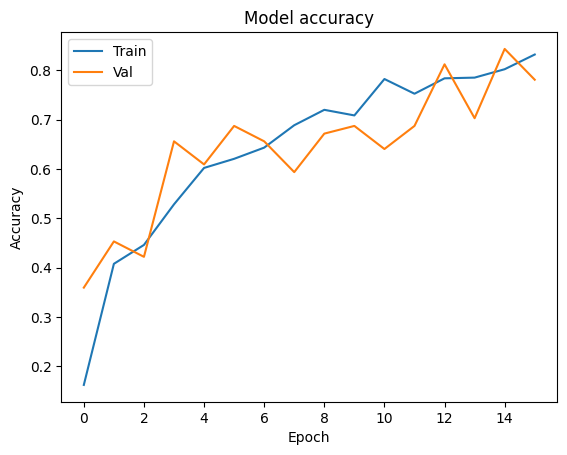

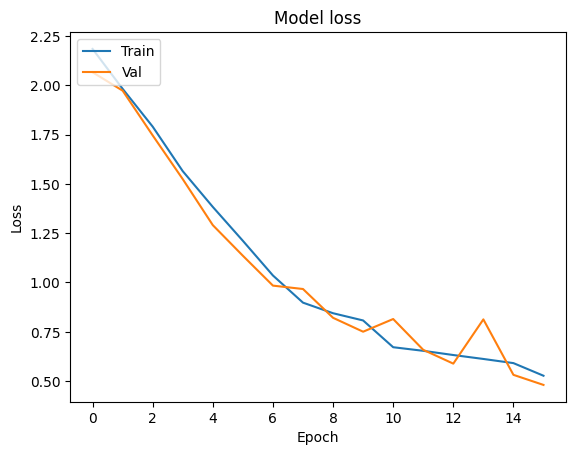

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8750 - loss: 0.3775
Test loss: 0.46765589714050293
Test accuracy: 0.8125


In [7]:
model_test1 = Sequential([
    LSTM(128, input_shape=X_shape, return_sequences=False),
    Dense(Y_shape, activation='softmax')
])
results["LSTM_single_layer"] = train_model(model_test1, 0.0001, EPOCH)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 128)            │       229,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 230,793 (901.54 KB)

 Trainable params: 230,793 (901.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 250ms/step - accuracy: 0.1209 - loss: 2.2449 - val_accuracy: 0.0469 - val_loss: 2.1698
Epoch 2/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - accuracy: 0.2259 - loss: 2.1056 - val_accuracy: 0.2812 - val_loss: 2.0906
Epoch 3/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 238ms/step - accuracy: 0.3598 - loss: 1.9973 - val_accuracy: 0.4531 - val_loss: 1.9920
Epoch 4/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 244ms/step - accuracy: 0.4040 - loss: 1.9337 - val_accuracy: 0.2188 - val_loss: 1.9310
Epoch 5/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step - accuracy: 0.3761 - loss: 1.8276 - val_accuracy: 0.5781 - val_loss: 1.8464
Epoch 6/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 389ms/step - accuracy: 0.4793 - loss: 1.7283 - val_accuracy: 0.3281 - val_loss: 1.7951
Epoch 7/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step - accuracy: 0.5141 - loss: 1.6720 - val_accuracy: 0.3906 - val_loss: 1.7194
Epoch 8/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/step - accuracy: 0.4742 - loss: 1.6021 - val_accuracy: 0.

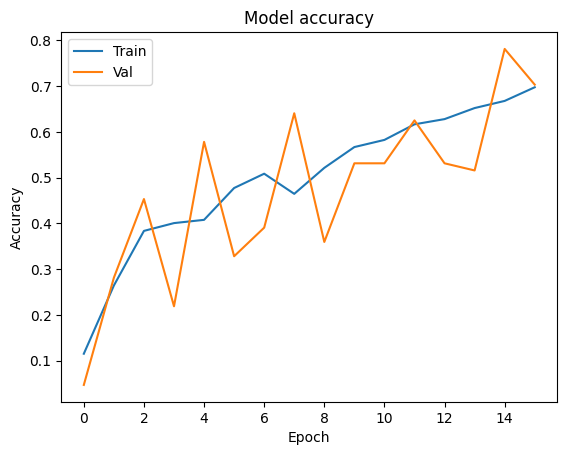

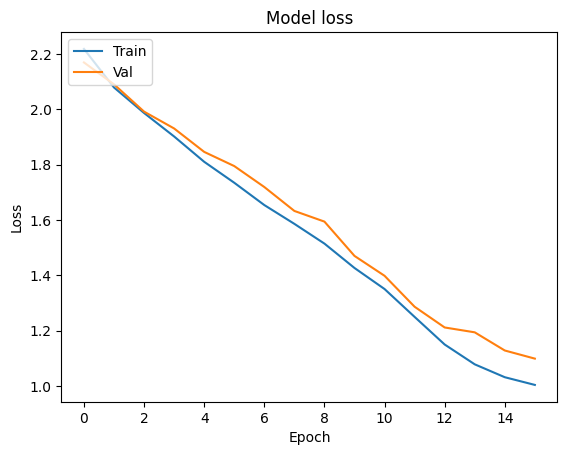

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7292 - loss: 1.0444
Test loss: 1.0737413167953491
Test accuracy: 0.734375


In [8]:
model_test2 = Sequential([
    GRU(128, input_shape=X_shape, return_sequences=False),
    Dense(Y_shape, activation='softmax')
])
results["GRU_single_layer"] = train_model(model_test2, 0.0001, EPOCH)

# Test 2: Multilayer

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 30, 128)        │       305,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 438,409 (1.67 MB)

 Trainable params: 438,409 (1.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 261ms/step - accuracy: 0.1487 - loss: 2.1886 - val_accuracy: 0.4688 - val_loss: 2.0710
Epoch 2/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 254ms/step - accuracy: 0.3268 - loss: 2.0033 - val_accuracy: 0.5000 - val_loss: 1.9134
Epoch 3/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 382ms/step - accuracy: 0.4040 - loss: 1.7704 - val_accuracy: 0.5625 - val_loss: 1.6789
Epoch 4/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 242ms/step - accuracy: 0.5535 - loss: 1.5309 - val_accuracy: 0.5000 - val_loss: 1.3713
Epoch 5/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 265ms/step - accuracy: 0.6138 - loss: 1.2445 - val_accuracy: 0.6719 - val_loss: 1.1227
Epoch 6/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 249ms/step - accuracy: 0.6835 - loss: 1.0025 - val_accuracy: 0.7031 - val_loss: 0.9587
Epoch 7/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 270ms/step - accuracy: 0.7235 - loss: 0.8574 - val_accuracy: 0.7031 - val_loss: 0.8014
Epoch 8/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 407ms/step - accuracy: 0.7564 - loss: 0.7250 - val_accuracy: 0.

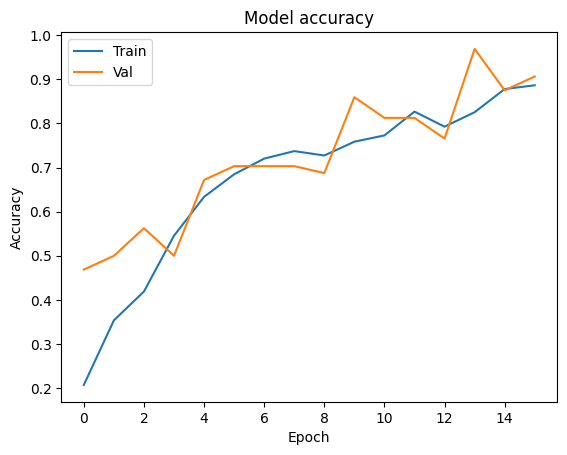

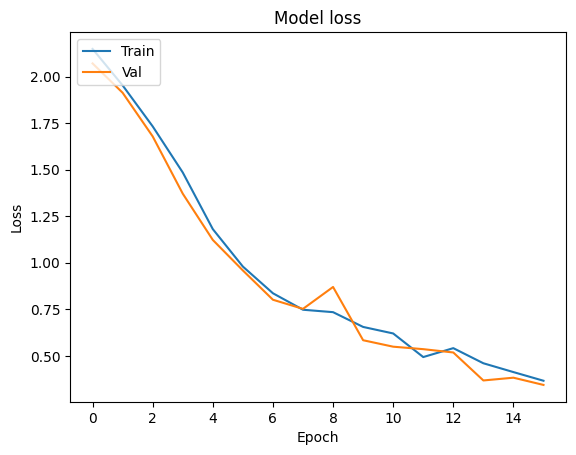

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9583 - loss: 0.2792
Test loss: 0.3494792580604553
Test accuracy: 0.9375


In [9]:
model_test3 = Sequential([
    LSTM(128, input_shape=X_shape, return_sequences=True),
    LSTM(128, return_sequences=False),
    Dense(Y_shape, activation='softmax')
])
results["LSTM_double_layer"] = train_model(model_test3, 0.0001, EPOCH)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 30, 128)        │       229,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,865 (1.26 MB)

 Trainable params: 329,865 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 293ms/step - accuracy: 0.1254 - loss: 2.2291 - val_accuracy: 0.1094 - val_loss: 2.1984
Epoch 2/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 287ms/step - accuracy: 0.2426 - loss: 2.0993 - val_accuracy: 0.3438 - val_loss: 2.0388
Epoch 3/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 274ms/step - accuracy: 0.3810 - loss: 1.9787 - val_accuracy: 0.5938 - val_loss: 1.9565
Epoch 4/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 406ms/step - accuracy: 0.4439 - loss: 1.8427 - val_accuracy: 0.5156 - val_loss: 1.8478
Epoch 5/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 267ms/step - accuracy: 0.5147 - loss: 1.7049 - val_accuracy: 0.5312 - val_loss: 1.7110
Epoch 6/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 266ms/step - accuracy: 0.5173 - loss: 1.6024 - val_accuracy: 0.6094 - val_loss: 1.6370
Epoch 7/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 266ms/step - accuracy: 0.5429 - loss: 1.4732 - val_accuracy: 0.5625 - val_loss: 1.5321
Epoch 8/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 275ms/step - accuracy: 0.6029 - loss: 1.4046 - val_accuracy: 0.

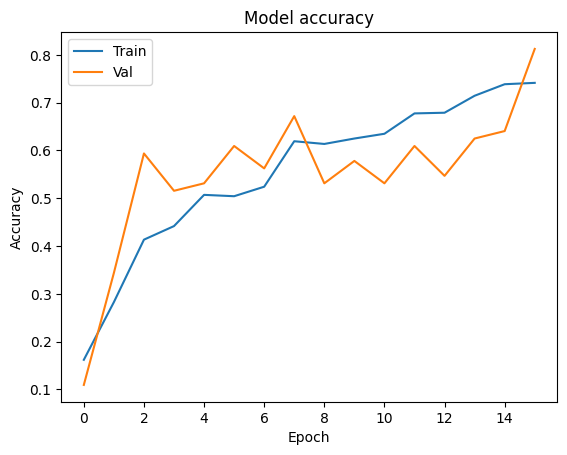

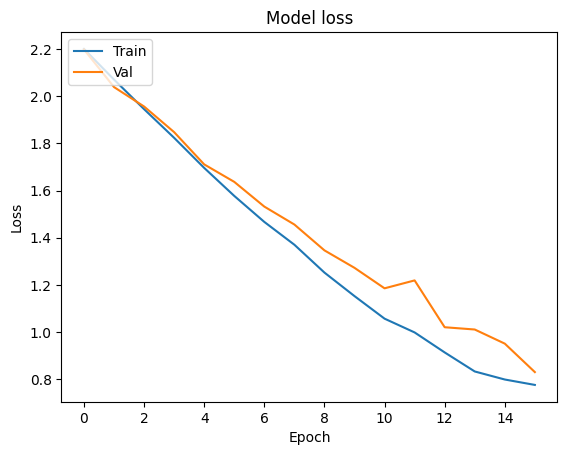

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7708 - loss: 0.7983
Test loss: 0.8269898891448975
Test accuracy: 0.734375


In [10]:
model_test4 = Sequential([
    GRU(128, input_shape=X_shape, return_sequences=True),
    GRU(128, return_sequences=False),
    Dense(Y_shape, activation='softmax')
])
results["GRU_double_layer"] = train_model(model_test4, 0.0001, EPOCH)

Now that we know LSTM is better, we test different learning rates.

# Test 3: Learning rates

Note: `lr=0.0001`, Test accuracy: 0.890625

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 30, 128)        │       305,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 438,409 (1.67 MB)

 Trainable params: 438,409 (1.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 262ms/step - accuracy: 0.1226 - loss: 2.1885 - val_accuracy: 0.0000e+00 - val_loss: 2.2116
Epoch 2/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 275ms/step - accuracy: 0.1623 - loss: 2.1719 - val_accuracy: 0.0000e+00 - val_loss: 2.1917
Epoch 3/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 285ms/step - accuracy: 0.1644 - loss: 2.1693 - val_accuracy: 0.0000e+00 - val_loss: 2.1716
Epoch 4/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 439ms/step - accuracy: 0.1906 - loss: 2.1502 - val_accuracy: 0.1094 - val_loss: 2.1553
Epoch 5/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 289ms/step - accuracy: 0.2347 - loss: 2.1364 - val_accuracy: 0.1250 - val_loss: 2.1362
Epoch 6/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 270ms/step - accuracy: 0.3033 - loss: 2.1010 - val_accuracy: 0.1719 - val_loss: 2.1184
Epoch 7/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 278ms/step - accuracy: 0.3292 - loss: 2.0781 - val_accuracy: 0.1719 - val_loss: 2.1006
Epoch 8/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 263ms/step - accuracy: 0.3276 - loss: 2.0668 - val_

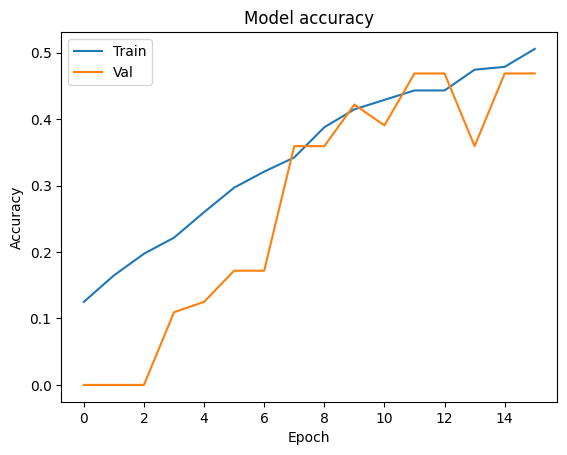

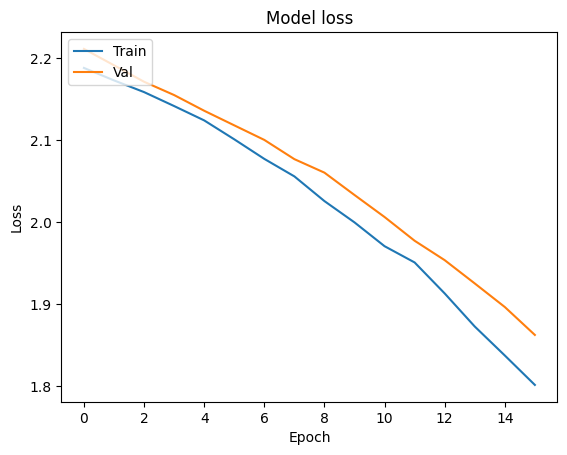

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5417 - loss: 1.8094
Test loss: 1.8583238124847412
Test accuracy: 0.46875


In [11]:
model_test5 = Sequential([
    LSTM(128, input_shape=X_shape, return_sequences=True),
    LSTM(128, return_sequences=False),
    Dense(Y_shape, activation='softmax')
])
results["LSTM_double_layer_lr_0.00001"] = train_model(model_test5, 0.00001, EPOCH)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 30, 128)        │       305,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 438,409 (1.67 MB)

 Trainable params: 438,409 (1.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 287ms/step - accuracy: 0.1917 - loss: 2.0651 - val_accuracy: 0.2969 - val_loss: 1.6121
Epoch 2/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - accuracy: 0.4525 - loss: 1.4243 - val_accuracy: 0.3438 - val_loss: 1.5382
Epoch 3/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.4851 - loss: 1.3118 - val_accuracy: 0.3438 - val_loss: 1.3902
Epoch 4/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 309ms/step - accuracy: 0.4766 - loss: 1.2832 - val_accuracy: 0.3281 - val_loss: 1.3809
Epoch 5/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - accuracy: 0.5209 - loss: 1.1415 - val_accuracy: 0.2812 - val_loss: 1.3085
Epoch 6/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 275ms/step - accuracy: 0.5195 - loss: 1.1197 - val_accuracy: 0.4844 - val_loss: 1.1527
Epoch 7/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 263ms/step - accuracy: 0.5469 - loss: 1.1060 - val_accuracy: 0.5469 - val_loss: 1.2702
Epoch 8/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 276ms/step - accuracy: 0.4872 - loss: 1.3685 - val_accuracy: 0.

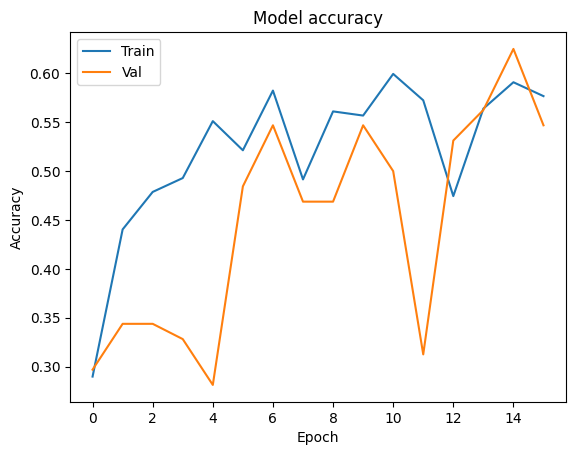

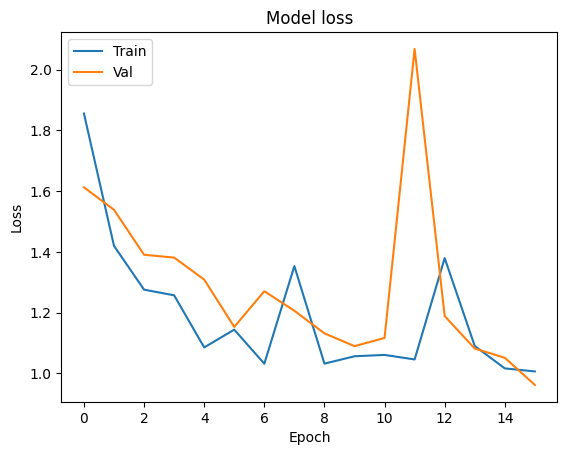

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5833 - loss: 0.9182
Test loss: 0.9300994873046875
Test accuracy: 0.546875


In [12]:
model_test6 = Sequential([
    LSTM(128, input_shape=X_shape, return_sequences=True),
    LSTM(128, return_sequences=False),
    Dense(Y_shape, activation='softmax')
])
results["LSTM_double_layer_lr_0.001"] = train_model(model_test6, 0.001, EPOCH)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 30, 128)        │       305,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 438,409 (1.67 MB)

 Trainable params: 438,409 (1.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 278ms/step - accuracy: 0.1301 - loss: 2.3501 - val_accuracy: 0.1562 - val_loss: 2.1172
Epoch 2/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 304ms/step - accuracy: 0.2650 - loss: 1.8891 - val_accuracy: 0.1562 - val_loss: 1.8391
Epoch 3/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 283ms/step - accuracy: 0.3642 - loss: 1.6112 - val_accuracy: 0.2188 - val_loss: 1.6474
Epoch 4/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 412ms/step - accuracy: 0.3334 - loss: 1.5994 - val_accuracy: 0.3125 - val_loss: 1.6075
Epoch 5/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 260ms/step - accuracy: 0.4270 - loss: 1.3731 - val_accuracy: 0.4531 - val_loss: 1.4878
Epoch 6/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 270ms/step - accuracy: 0.3610 - loss: 1.5693 - val_accuracy: 0.2031 - val_loss: 1.6100
Epoch 7/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 254ms/step - accuracy: 0.4092 - loss: 1.4502 - val_accuracy: 0.3906 - val_loss: 1.4403
Epoch 8/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.5078 - loss: 1.2429 - val_accuracy: 0.

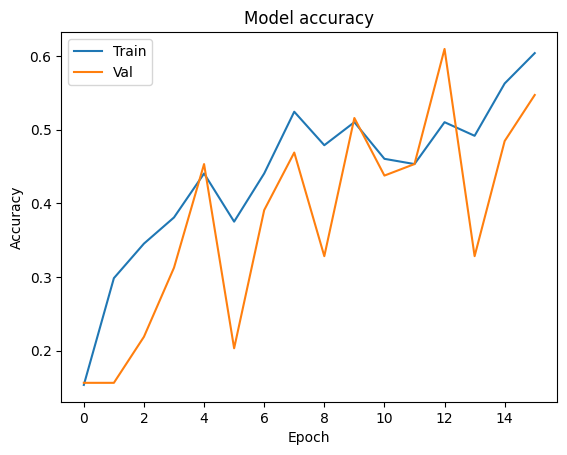

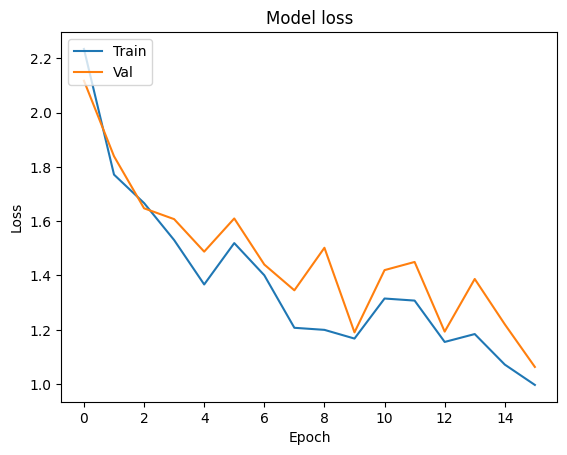

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6146 - loss: 1.0017
Test loss: 1.067449927330017
Test accuracy: 0.546875


In [13]:
model_test7 = Sequential([
    LSTM(128, input_shape=X_shape, return_sequences=True),
    LSTM(128, return_sequences=False),
    Dense(Y_shape, activation='softmax')
])
results["LSTM_double_layer_lr_0.01"] = train_model(model_test7, 0.01, EPOCH)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 30, 128)        │       305,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 438,409 (1.67 MB)

 Trainable params: 438,409 (1.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 308ms/step - accuracy: 0.1141 - loss: 4.1378 - val_accuracy: 0.0625 - val_loss: 2.7896
Epoch 2/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.1240 - loss: 2.4021 - val_accuracy: 0.1562 - val_loss: 2.2025
Epoch 3/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step - accuracy: 0.0993 - loss: 2.3293 - val_accuracy: 0.0625 - val_loss: 2.5463
Epoch 4/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 0.0874 - loss: 2.4291 - val_accuracy: 0.1562 - val_loss: 2.1922
Epoch 5/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 0.0987 - loss: 2.3715 - val_accuracy: 0.0625 - val_loss: 2.4849
Epoch 6/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - accuracy: 0.1187 - loss: 2.3528 - val_accuracy: 0.0625 - val_loss: 2.4723
Epoch 7/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - accuracy: 0.1232 - loss: 2.3622 - val_accuracy: 0.1562 - val_loss: 2.3113
Epoch 8/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step - accuracy: 0.0887 - loss: 2.3346 - val_accuracy: 0.

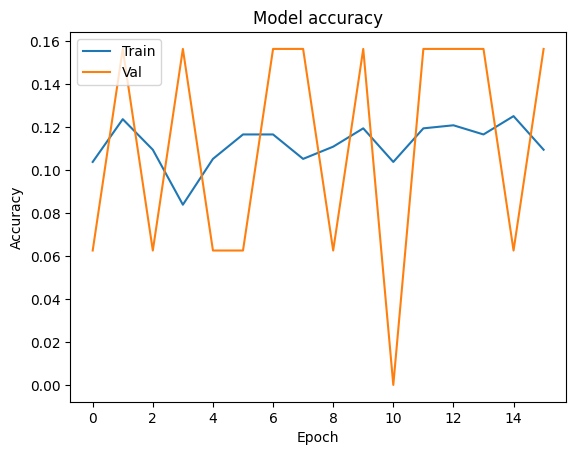

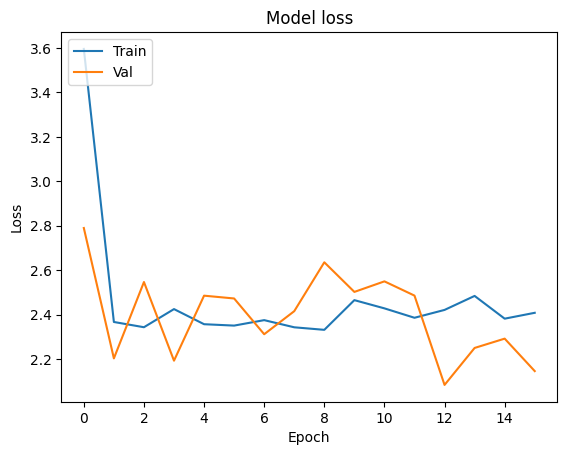

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2083 - loss: 2.1146
Test loss: 2.145296573638916
Test accuracy: 0.15625


In [14]:
model_test8 = Sequential([
    LSTM(128, input_shape=X_shape, return_sequences=True),
    LSTM(128, return_sequences=False),
    Dense(Y_shape, activation='softmax')
])
results["LSTM_double_layer_lr_0.1"] = train_model(model_test8, 0.1, EPOCH)

# Test 4: LSTM Unit count

Note: 128 units, Test accuracy: 0.890625

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 30, 64)         │       136,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 170,057 (664.29 KB)

 Trainable params: 170,057 (664.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step - accuracy: 0.1135 - loss: 2.2231 - val_accuracy: 0.1250 - val_loss: 2.1643
Epoch 2/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - accuracy: 0.2255 - loss: 2.1488 - val_accuracy: 0.1562 - val_loss: 2.0850
Epoch 3/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.2540 - loss: 2.0650 - val_accuracy: 0.3125 - val_loss: 1.9802
Epoch 4/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.3846 - loss: 1.9075 - val_accuracy: 0.3125 - val_loss: 1.8332
Epoch 5/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.3668 - loss: 1.7774 - val_accuracy: 0.4062 - val_loss: 1.7438
Epoch 6/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 245ms/step - accuracy: 0.4159 - loss: 1.6616 - val_accuracy: 0.4531 - val_loss: 1.6494
Epoch 7/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 286ms/step - accuracy: 0.5096 - loss: 1.5332 - val_accuracy: 0.5781 - val_loss: 1.5259
Epoch 8/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 235ms/step - accuracy: 0.5247 - loss: 1.4468 - val_accuracy: 0.

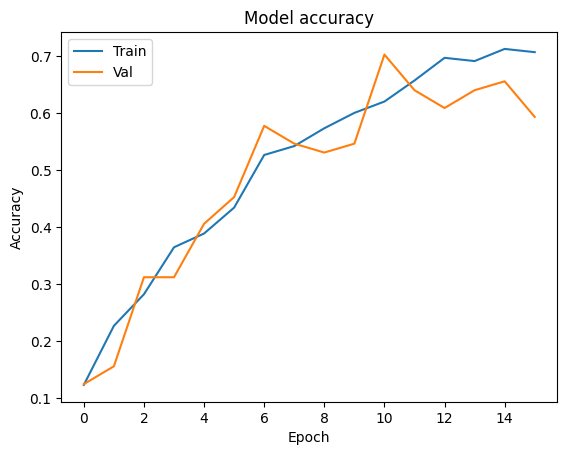

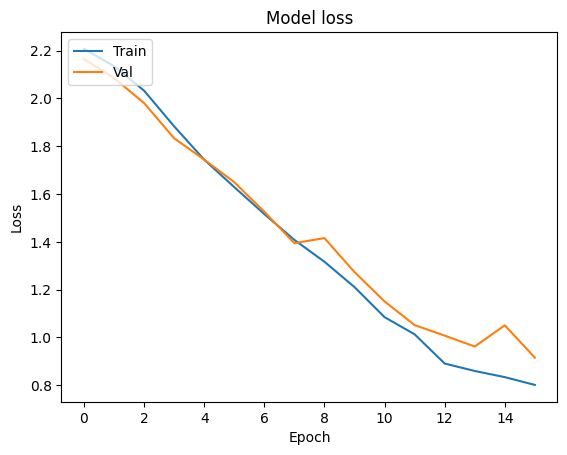

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.6250 - loss: 0.8538
Test loss: 0.8665380477905273
Test accuracy: 0.625


In [15]:
model_test9 = Sequential([
    LSTM(64, input_shape=X_shape, return_sequences=True),
    LSTM(64, return_sequences=False),
    Dense(Y_shape, activation='softmax')
])
results["LSTM_double_layer_64"] = train_model(model_test9, 0.0001, EPOCH)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                  │ (None, 30, 256)        │       742,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,270,025 (4.84 MB)

 Trainable params: 1,270,025 (4.84 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.2002 - loss: 2.1521 - val_accuracy: 0.3438 - val_loss: 1.9010
Epoch 2/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step - accuracy: 0.4067 - loss: 1.7238 - val_accuracy: 0.3125 - val_loss: 1.5559
Epoch 3/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - accuracy: 0.5442 - loss: 1.3996 - val_accuracy: 0.6562 - val_loss: 1.2303
Epoch 4/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - accuracy: 0.6100 - loss: 1.1151 - val_accuracy: 0.5625 - val_loss: 1.0368
Epoch 5/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - accuracy: 0.6255 - loss: 0.9168 - val_accuracy: 0.7031 - val_loss: 0.8668
Epoch 6/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.7090 - loss: 0.7561 - val_accuracy: 0.6562 - val_loss: 1.0054
Epoch 7/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.8089 - loss: 0.5985 - val_accuracy: 0.7344 - val_loss: 0.6911
Epoch 8/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - accuracy: 0.7544 - loss: 0.5944 - val_accuracy: 0.

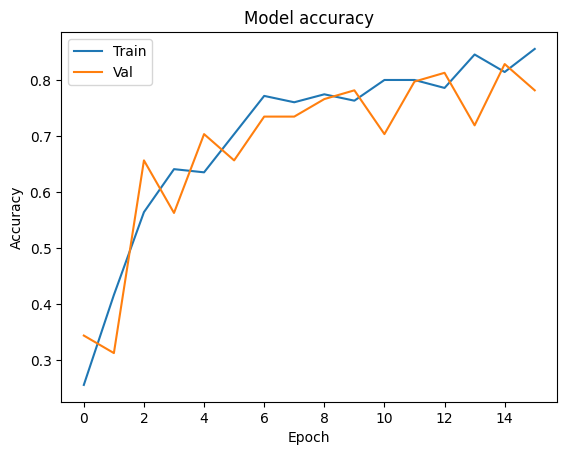

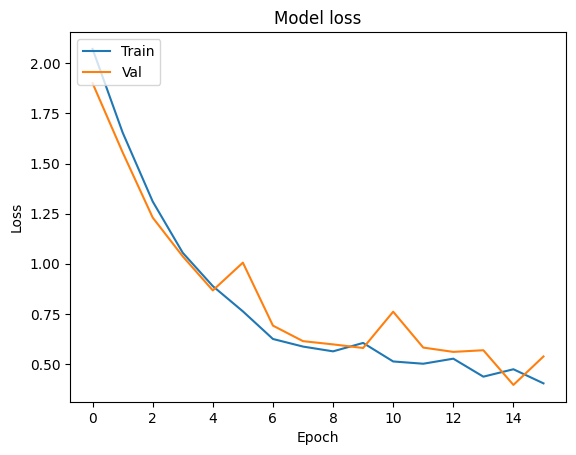

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8333 - loss: 0.3834
Test loss: 0.4740810990333557
Test accuracy: 0.78125


In [16]:
model_test10 = Sequential([
    LSTM(256, input_shape=X_shape, return_sequences=True),
    LSTM(256, return_sequences=False),
    Dense(Y_shape, activation='softmax')
])
results["LSTM_double_layer_256"] = train_model(model_test10, 0.0001, EPOCH)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 30, 512)        │     2,009,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 512)            │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,112,905 (15.69 MB)

 Trainable params: 4,112,905 (15.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 313ms/step - accuracy: 0.1945 - loss: 2.1366 - val_accuracy: 0.4688 - val_loss: 1.7673
Epoch 2/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step - accuracy: 0.5170 - loss: 1.5285 - val_accuracy: 0.4219 - val_loss: 1.4643
Epoch 3/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - accuracy: 0.5340 - loss: 1.1857 - val_accuracy: 0.6875 - val_loss: 1.0226
Epoch 4/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - accuracy: 0.6621 - loss: 0.8865 - val_accuracy: 0.7969 - val_loss: 0.7819
Epoch 5/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - accuracy: 0.7521 - loss: 0.7536 - val_accuracy: 0.6562 - val_loss: 0.7119
Epoch 6/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step - accuracy: 0.6535 - loss: 0.9010 - val_accuracy: 0.6094 - val_loss: 1.0028
Epoch 7/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - accuracy: 0.7042 - loss: 0.7645 - val_accuracy: 0.7812 - val_loss: 0.6032
Epoch 8/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - accuracy: 0.8421 - loss: 0.4898 - val_accuracy: 0.

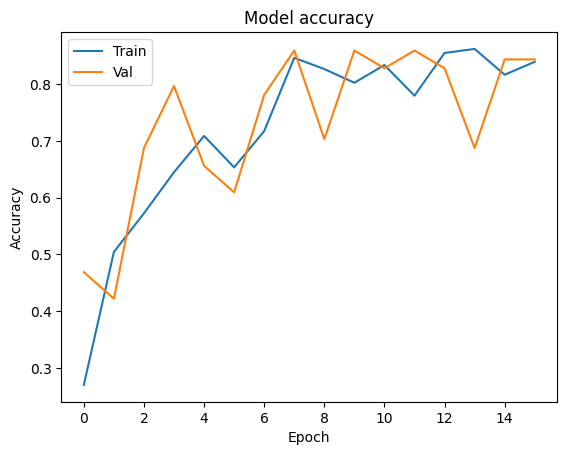

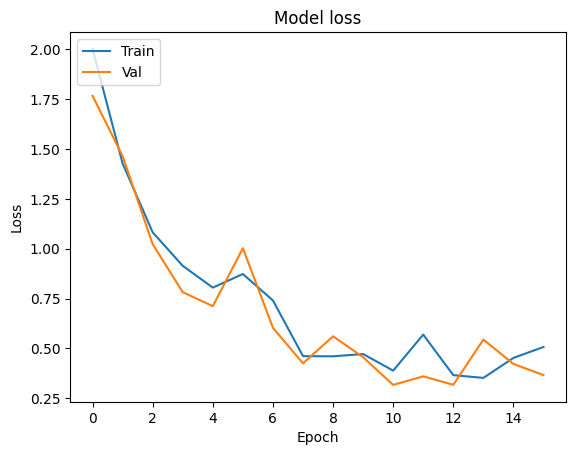

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8854 - loss: 0.3220
Test loss: 0.39346206188201904
Test accuracy: 0.84375


In [17]:
model_test11 = Sequential([
    LSTM(512, input_shape=X_shape, return_sequences=True),
    LSTM(512, return_sequences=False),
    Dense(Y_shape, activation='softmax')
])
results["LSTM_double_layer_512"] = train_model(model_test11, 0.0001, EPOCH)

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                  │ (None, 30, 1024)       │     6,115,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 1024)           │     8,392,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 9)              │         9,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,517,257 (55.38 MB)

 Trainable params: 14,517,257 (55.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - accuracy: 0.2278 - loss: 2.0441 - val_accuracy: 0.1875 - val_loss: 1.9393
Epoch 2/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 347ms/step - accuracy: 0.4627 - loss: 1.3916 - val_accuracy: 0.4844 - val_loss: 1.0684
Epoch 3/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - accuracy: 0.5516 - loss: 1.1514 - val_accuracy: 0.5781 - val_loss: 0.9558
Epoch 4/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step - accuracy: 0.7009 - loss: 0.8337 - val_accuracy: 0.6875 - val_loss: 0.7638
Epoch 5/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step - accuracy: 0.7164 - loss: 0.7123 - val_accuracy: 0.6406 - val_loss: 0.7270
Epoch 6/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - accuracy: 0.7152 - loss: 0.7074 - val_accuracy: 0.7188 - val_loss: 0.6739
Epoch 7/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - accuracy: 0.8181 - loss: 0.4922 - val_accuracy: 0.7656 - val_loss: 0.4677
Epoch 8/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - accuracy: 0.7853 - loss: 0.5694 - val_accuracy: 0.

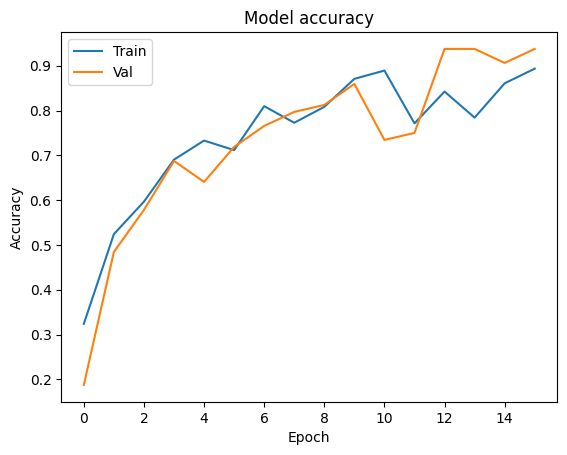

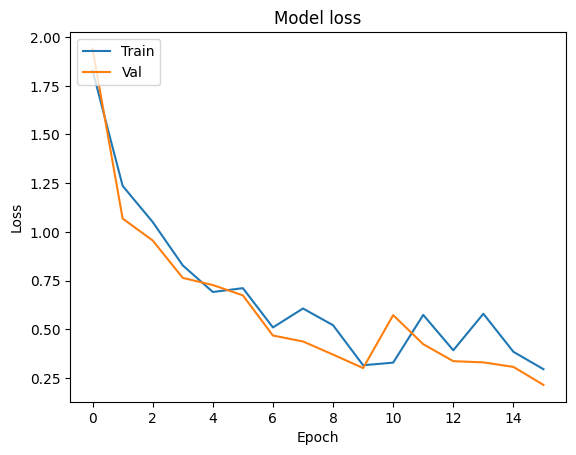

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9375 - loss: 0.1958
Test loss: 0.2823769152164459
Test accuracy: 0.90625


In [18]:
model_test12 = Sequential([
    LSTM(1024, input_shape=X_shape, return_sequences=True),
    LSTM(1024, return_sequences=False),
    Dense(Y_shape, activation='softmax')
])
results["LSTM_double_layer_1024"] = train_model(model_test12, 0.0001, EPOCH)

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_19 (LSTM)                  │ (None, 30, 2048)       │    20,619,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 2048)           │    33,562,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 9)              │        18,441 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,200,329 (206.76 MB)

 Trainable params: 54,200,329 (206.76 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 458ms/step - accuracy: 0.2232 - loss: 2.0701 - val_accuracy: 0.4844 - val_loss: 1.4330
Epoch 2/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 522ms/step - accuracy: 0.5382 - loss: 1.2489 - val_accuracy: 0.5312 - val_loss: 1.1211
Epoch 3/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 341ms/step - accuracy: 0.6005 - loss: 0.9900 - val_accuracy: 0.6250 - val_loss: 0.8678
Epoch 4/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 342ms/step - accuracy: 0.7072 - loss: 0.7797 - val_accuracy: 0.7656 - val_loss: 0.6871
Epoch 5/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 339ms/step - accuracy: 0.7260 - loss: 0.6577 - val_accuracy: 0.6875 - val_loss: 0.7235
Epoch 6/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 483ms/step - accuracy: 0.7375 - loss: 0.6667 - val_accuracy: 0.8438 - val_loss: 0.5081
Epoch 7/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 344ms/step - accuracy: 0.8050 - loss: 0.5798 - val_accuracy: 0.8750 - val_loss: 0.4692
Epoch 8/16
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 344ms/step - accuracy: 0.7610 - loss: 0.6059 - val_accuracy:

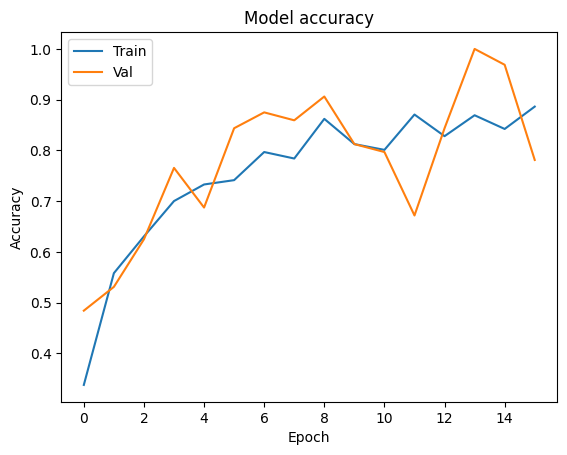

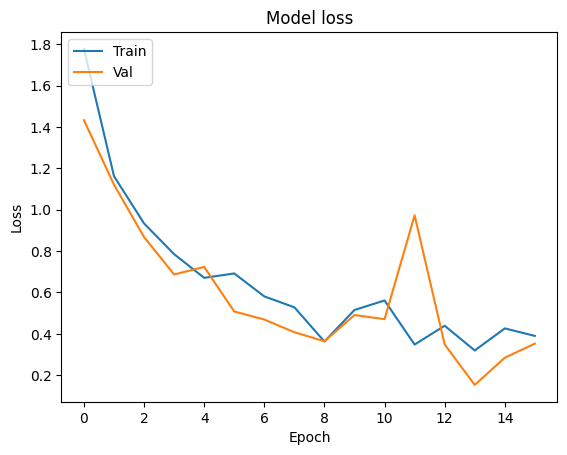

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8125 - loss: 0.3319
Test loss: 0.3720914125442505
Test accuracy: 0.78125


In [19]:
model_test13 = Sequential([
    LSTM(2048, input_shape=X_shape, return_sequences=True),
    LSTM(2048, return_sequences=False),
    Dense(Y_shape, activation='softmax')
])
results["LSTM_double_layer_2048"] = train_model(model_test13, 0.0001, EPOCH)

# Summary

In [20]:
for key, value in results.items():
    print(key, value)

LSTM_single_layer (0.8323863744735718, 0.78125, 0.8125)
GRU_single_layer (0.6974431872367859, 0.703125, 0.734375)
LSTM_double_layer (0.8863636255264282, 0.90625, 0.9375)
GRU_double_layer (0.7414772510528564, 0.8125, 0.734375)
LSTM_double_layer_lr_0.00001 (0.5056818127632141, 0.46875, 0.46875)
LSTM_double_layer_lr_0.001 (0.5767045617103577, 0.546875, 0.546875)
LSTM_double_layer_lr_0.01 (0.6036931872367859, 0.546875, 0.546875)
LSTM_double_layer_lr_0.1 (0.109375, 0.15625, 0.15625)
LSTM_double_layer_64 (0.7073863744735718, 0.59375, 0.625)
LSTM_double_layer_256 (0.8551136255264282, 0.78125, 0.78125)
LSTM_double_layer_512 (0.8394886255264282, 0.84375, 0.84375)
LSTM_double_layer_1024 (0.8934659361839294, 0.9375, 0.90625)
LSTM_double_layer_2048 (0.8863636255264282, 0.78125, 0.78125)


# Conclusion

From the above experiments, we get
- LSTM is **way** better than GRU
- Multi-layer is better than single layer
- `lr=0.0001`
- Units: `256`